In [158]:
library('dplyr')
library('broom')
library('ggplot2')
library('macc')
library('olsrr')
library('pls')
library('reshape2')

MyClass <- setRefClass("MyClass",
                       fields = list(
                         data = "data.frame",
                         model = "lm",
                         dffits_values = "numeric",
                         model_step = "numeric",
                         coef_df = 'data.frame',
                         steps_stepwise_reg = "list",
                         sbc_stepwise_reg = "list"
                       ),
methods = list(
  preparing_data = function()
  {
    data <<- na.omit(data)
    data$Origin <<- as.factor(data$Origin)
    data$Type <<- as.factor(data$Type)
    data$Invoice <<- as.numeric(gsub("[$,]", "", data$Invoice))
  },

  calculate_BIC = function(model, data)
  {
    RSS <- sum(model$residuals^2)
    n <- nrow(data)
    p <- length(coef(model))
    return (n * log(RSS / n) + p * log(n))
  },

  grouping_levels = function(Param)
  {
      data[[Param]] <<- droplevels(data[[Param]])
      params <- levels(data[[Param]])
      results <- data.frame(Param1 = character(), Param2 = character(), p_value = numeric(), stringsAsFactors = FALSE)
      for (i in 1:(length(params) - 1))
      {
        for (j in (i + 1):length(params))
        {
          param1 <- params[i]
          param2 <- params[j]

          # Выбор данных для t-теста
          data1 <- data$MPG_City[data[[Param]] == param1]
          data2 <- data$MPG_City[data[[Param]] == param2]

          t_test_result <- t.test(data1, data2, var.equal = TRUE)

          # Сохранение результатов
          results <- rbind(results, data.frame(Param1 = param1, Param2 = param2, p_value = t_test_result$p.value))
        }
      }

      # Объединение уровней на основе p-value
      for (row in 1:nrow(results)) {
        if (results$p_value[row] > 0.05) {
          # Объединение типов
          param1 <- results$Param1[row]
          param2 <- results$Param2[row]

          # Новое название уровня
          new_level <- paste(param1, "and", param2, sep = "_")

          data[[Param]] <<- factor(data[[Param]], levels = c(levels(data[[Param]]), new_level))

          data[[Param]][data[[Param]] == param2 | data[[Param]] == param1 ] <<- new_level
        }
      }

      # Преобразование в фактор с новыми уровнями
      data[[Param]] <<- factor(data[[Param]])
      data[[Param]] <<- droplevels(data[[Param]])
  },

  delete_outliers = function()
  {
      n <- nrow(data)
      p <- length(coef(model))
      threshold <- 2 * sqrt(p / n)
      outliers <- which(abs(dffits_values) > threshold)
      data <<- data[-outliers,]
  },

  res_pred_graph = function()
  {
      residuals <- resid(model)
      predicted <- predict(model)
      res_and_pred <- data.frame(residuals, predicted)

      base::plot(res_and_pred$predicted, res_and_pred$residuals,
      main = "Зависимость остатков от предсказанных значений",
      xlab = "Предсказанные значения",
      ylab = "Остатки",
      pch = 16)

      abline(h = 0, lty = 2, col = "red")
  },

  res_pred_hist = function()
  {
      residuals <- resid(model)
      predicted <- predict(model)
      res_and_pred <- data.frame(residuals, predicted)
      hist(res_and_pred$residuals,
      col = "blue",
      border = "black",
      main = "Гистограмма распределения остатков",
      xlab = "Остатки",
      ylab = "Частота")
  },

  dffits_values_plot = function()
  {
      #3 наиболее аномальных наблюдения
      top_dffits_indexes <- order(abs(dffits_values), decreasing = TRUE)[1:3]

      base::plot(dffits_values, type = "h", main = "DFFITS Values", xlab = "Index", ylab = "DFFITS", col = "blue")
      points(top_dffits_indexes, dffits_values[top_dffits_indexes], col = "red", pch = 19, cex = 1.5)  # Отметка аномальных наблюдений
      legend("bottomright", legend = c("DFFITS", "Top 3 anomalies"), col = c("blue", "red"), pch = c(NA, 19), lty = c(1, NA))
  },

  coefficient_trace_plot = function()
  {
        unique_variables <- unique(coef_df$variable)
        par(mfrow = c(2, ceiling(length(unique_variables) / 2)))
        for (var in unique_variables)
      {
        subset_df <- coef_df[coef_df$variable == var, ]
        base::plot(subset_df$Step, subset_df$value, type = "b", pch = 19, col = "blue",
          xlab = "Шаг", ylab = "Коэффициенты",
          main = var)
        lines(subset_df$Step, subset_df$value, col = "blue")
      }
      par(mfrow = c(1, 1))
  },

  fit = function(train_data, step = 1)
  {
    model_step <<- step
    data <<- train_data

    if (model_step >= 1)
    {
       preparing_data()
       model <<- lm(MPG_City ~ Length + Weight + Wheelbase + Horsepower + Invoice + EngineSize + Cylinders + Origin + Type, data = data)
    }

    if (model_step >= 2)
    {
      dffits_values <<- dffits(model)
      delete_outliers()
      model <<- lm(MPG_City ~ Length + Weight + Wheelbase + Horsepower + Invoice + EngineSize + Cylinders + Origin + Type, data = data )
    }

    if (model_step >= 3)
    {
      #группировка по типам
      grouping_levels('Type')

      #группировка по странам
      grouping_levels('Origin')

      model <<- lm(MPG_City ~ Length + Weight + Wheelbase + Horsepower + Invoice + EngineSize + Cylinders + Origin + Type, data = data)
    }

    if (model_step == 4)
    {
      stepwise_reg <- ols_step_forward_sbc(model)
      coef_df <<- data.frame(matrix(NA, nrow = max(stepwise_reg$metrics$step), ncol = length(stepwise_reg$model$coefficients)-1))
      colnames(coef_df) <<- names(stepwise_reg$model$coefficients)[-1]
      coef_df[is.na(coef_df)] <<- 0

      for (i in 1:nrow(coef_df)) {
        # Формируем формулу для текущего шага
        formula_str <- as.formula(paste("MPG_City ~", paste(stepwise_reg$metrics$variable[1:i], collapse = " + ")))
        step_model <- lm(formula_str, data = data)
        coef_df[i, 1:(length(step_model$coefficients)-1)] <<- coef(step_model)[-1]
      }

      coef_df$Step <<- 1:nrow(coef_df)
      coef_df <<- melt(coef_df, id.vars = "Step")
      # сохраняем модель, получившуюся на последнем шаге
      model <<- step_model
      steps_stepwise_reg <<- as.list(stepwise_reg$metrics$step)
      sbc_stepwise_reg <<- as.list(stepwise_reg$metrics$sbc)
    }
  },

  summary = function()
  {
      r_squared <- base::summary(model)$r.squared
      adj_r_squared <- base::summary(model)$adj.r.squared
      bic <- BIC(model)
      print(base::summary(model))
      cat("R^2:", r_squared, "\n")
      cat("MSE:", adj_r_squared, "\n")
      cat("BIC:", bic, "\n")
  },

  plot = function()
  {
      if (model_step == 1)
      {
        res_pred_graph()
        res_pred_hist()
      }

      if (model_step == 2)
      {
        res_pred_graph()
        res_pred_hist()
        dffits_values_plot()
      }

      if (model_step == 3)
      {
        res_pred_graph()
        res_pred_hist()
      }

    if (model_step == 4)
    {
      res_pred_graph()
      res_pred_hist()
      coefficient_trace_plot()
      base::plot(steps_stepwise_reg, sbc_stepwise_reg, type='l', main = 'график зависимости качества модели', xlab = 'Шаг', ylab = 'BIC')
    }
  }
)
)

### Пункт 1


Call:
lm(formula = MPG_City ~ Length + Weight + Wheelbase + Horsepower + 
    Invoice + EngineSize + Cylinders + Origin + Type, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.0909 -1.3744 -0.0822  0.8463 14.0829 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   6.470e+01  2.671e+00  24.225  < 2e-16 ***
Length       -4.716e-02  1.766e-02  -2.671  0.00786 ** 
Weight       -2.942e-03  3.682e-04  -7.991 1.36e-14 ***
Wheelbase     7.933e-02  3.416e-02   2.322  0.02072 *  
Horsepower   -1.846e-02  3.826e-03  -4.826 1.97e-06 ***
Invoice       3.391e-05  1.227e-05   2.764  0.00597 ** 
EngineSize   -3.345e-01  3.234e-01  -1.034  0.30160    
Cylinders    -2.315e-01  1.813e-01  -1.277  0.20245    
OriginEurope -1.084e+00  3.375e-01  -3.212  0.00142 ** 
OriginUSA    -2.701e-01  2.736e-01  -0.987  0.32419    
TypeSedan    -2.786e+01  1.259e+00 -22.129  < 2e-16 ***
TypeSports   -2.943e+01  1.335e+00 -22.051  < 2e-16 ***
TypeSUV      -2.905e+

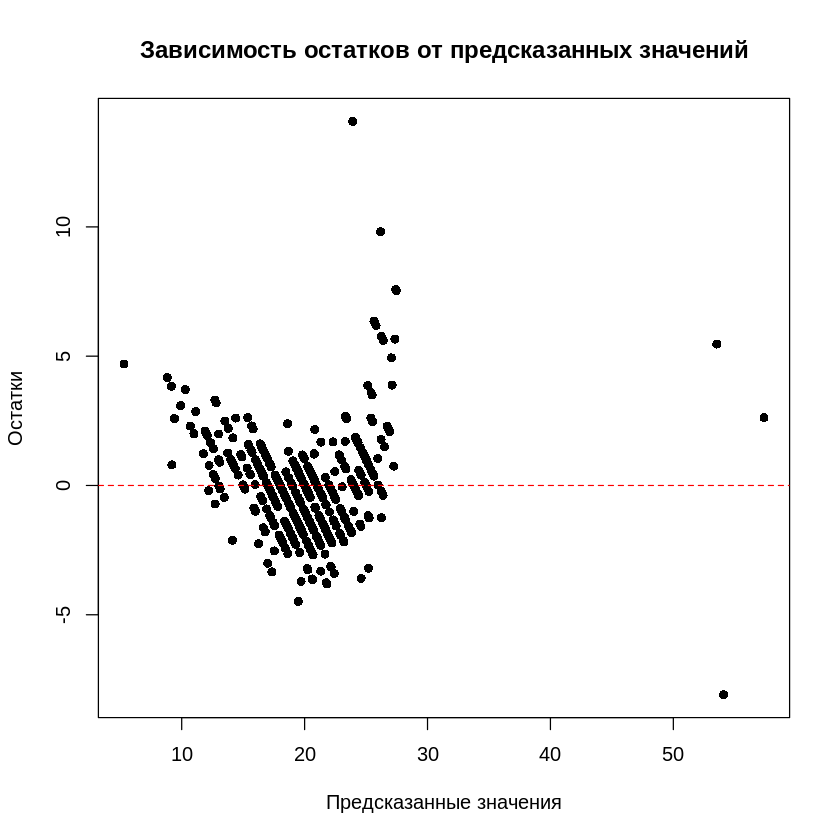

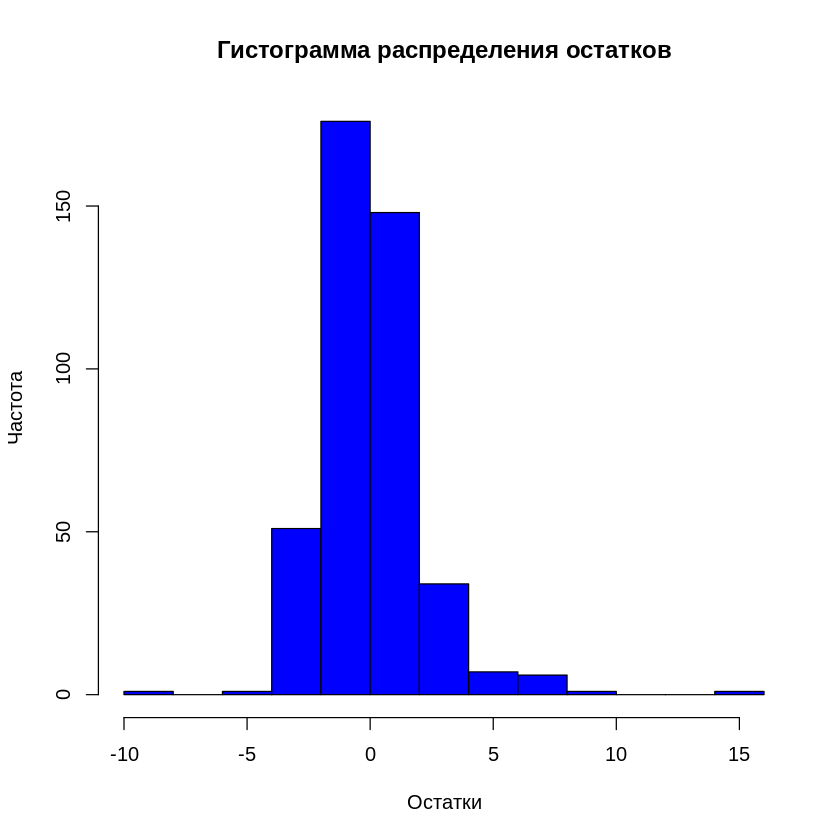

In [159]:
df <- read.csv('CARS.csv')
obj <- MyClass$new()
obj$fit(df,step=1)
obj$summary()
obj$plot()

Наиболее значимая переменная по критерию Стьюдента - тип Кузова, наиболее НЕ значимая - страна-производитель США. Наблюдается гетероскедастичность остатков, что указывает на некорректность модели

### Пункт 2


Call:
lm(formula = MPG_City ~ Length + Weight + Wheelbase + Horsepower + 
    Invoice + EngineSize + Cylinders + Origin + Type, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4856 -1.1965  0.0241  0.8581  6.5875 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.438e+01  2.074e+00  16.577  < 2e-16 ***
Length       -3.367e-02  1.430e-02  -2.355 0.019036 *  
Weight       -3.200e-03  3.121e-04 -10.256  < 2e-16 ***
Wheelbase     8.406e-02  2.779e-02   3.024 0.002658 ** 
Horsepower   -1.612e-02  3.018e-03  -5.343 1.57e-07 ***
Invoice       4.517e-05  1.187e-05   3.804 0.000165 ***
EngineSize   -4.346e-01  2.662e-01  -1.632 0.103420    
Cylinders    -3.013e-01  1.507e-01  -1.999 0.046288 *  
OriginEurope -1.152e+00  2.826e-01  -4.077 5.54e-05 ***
OriginUSA    -1.515e-01  2.197e-01  -0.690 0.490853    
TypeSports   -1.273e+00  3.702e-01  -3.438 0.000649 ***
TypeSUV      -7.874e-01  3.495e-01  -2.253 0.024840 *  
TypeTruck    -1.536e+

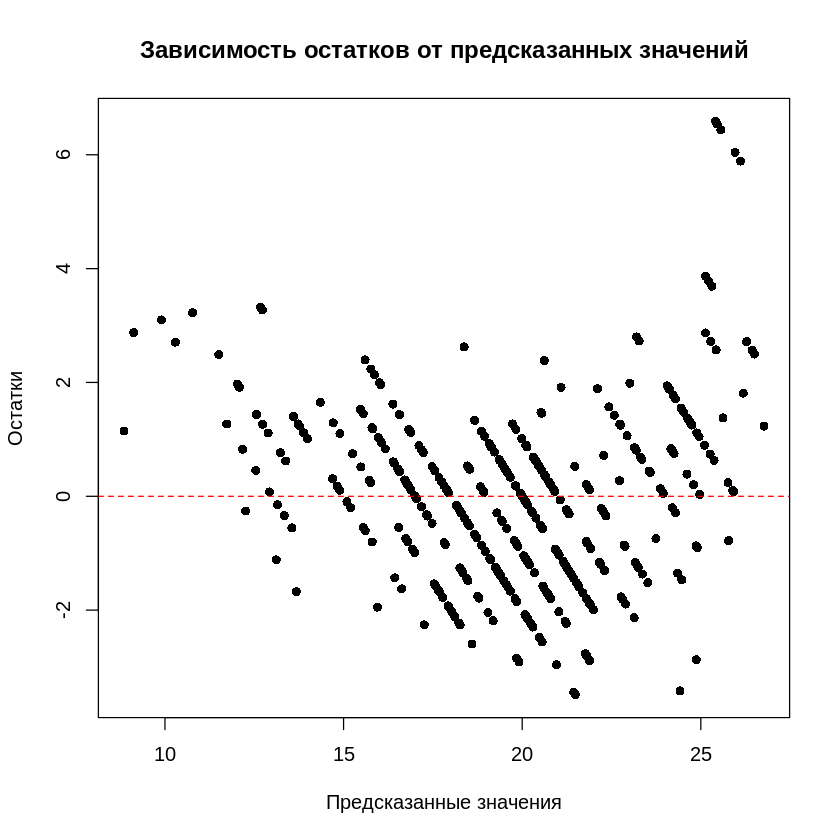

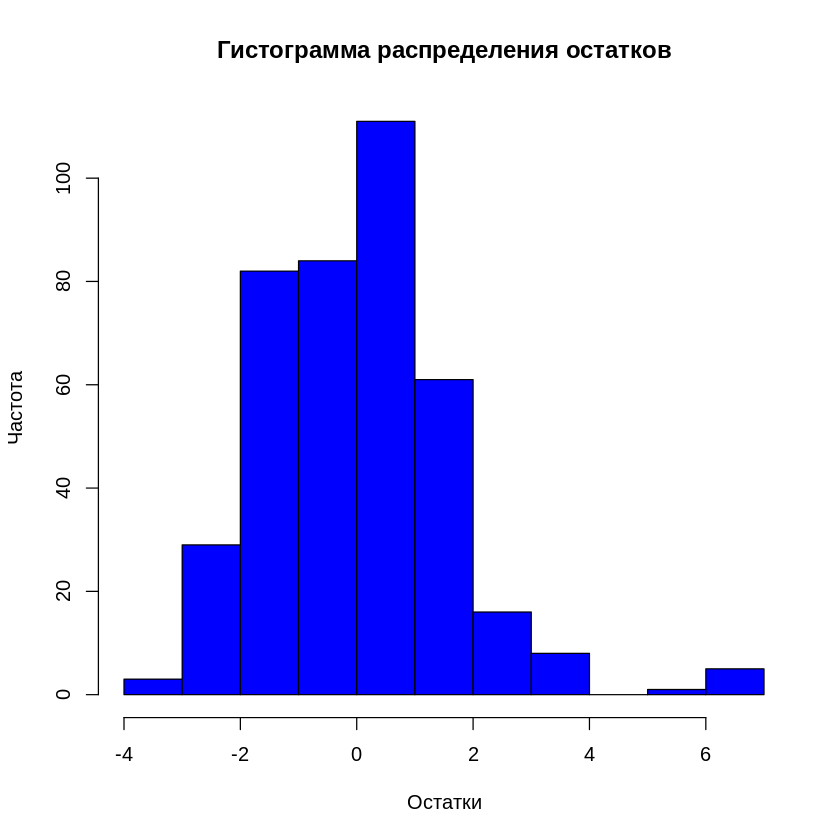

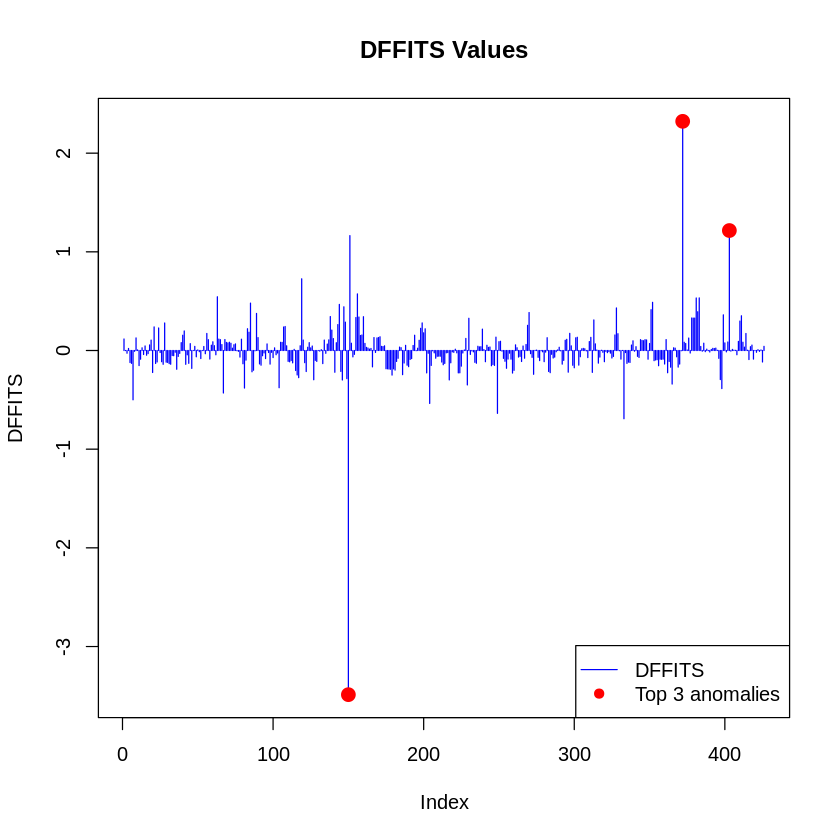

In [160]:
df <- read.csv('CARS.csv')
obj <- MyClass$new()
obj$fit(df,step=2)
obj$summary()
obj$plot()

Значения R^2 и исправленного R^2 незначительно уменьшились, при этом значение BIC уменьшилось, что указывает на то, что получившаяся модель предпочтительнее предыдущей. Кроме того, теперь остатки распределены более однородно, но условия применимости не выполняются (остатки образуют прямые линии, что указывает на наличие зависимости). В данной моделе наиболее значимой переменной является вес, а наиболее незначимой Тип кузова Wagon

### Пункт 3


Call:
lm(formula = MPG_City ~ Length + Weight + Wheelbase + Horsepower + 
    Invoice + EngineSize + Cylinders + Origin + Type, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2943 -1.1784 -0.0292  0.8467  6.5549 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           3.342e+01  1.706e+00  19.585  < 2e-16 ***
Length               -2.073e-02  1.371e-02  -1.512  0.13136    
Weight               -3.496e-03  2.974e-04 -11.754  < 2e-16 ***
Wheelbase             7.815e-02  2.626e-02   2.976  0.00310 ** 
Horsepower           -1.683e-02  2.971e-03  -5.664 2.88e-08 ***
Invoice               3.137e-05  1.078e-05   2.909  0.00384 ** 
EngineSize           -5.040e-02  2.365e-01  -0.213  0.83138    
Cylinders            -3.957e-01  1.476e-01  -2.681  0.00765 ** 
OriginEurope_and_USA -5.066e-01  1.875e-01  -2.702  0.00719 ** 
TypeSports_and_Truck -1.306e+00  2.614e-01  -4.996 8.88e-07 ***
TypeSUV_and_Truck    -5.531e-01  3.389e-01  -

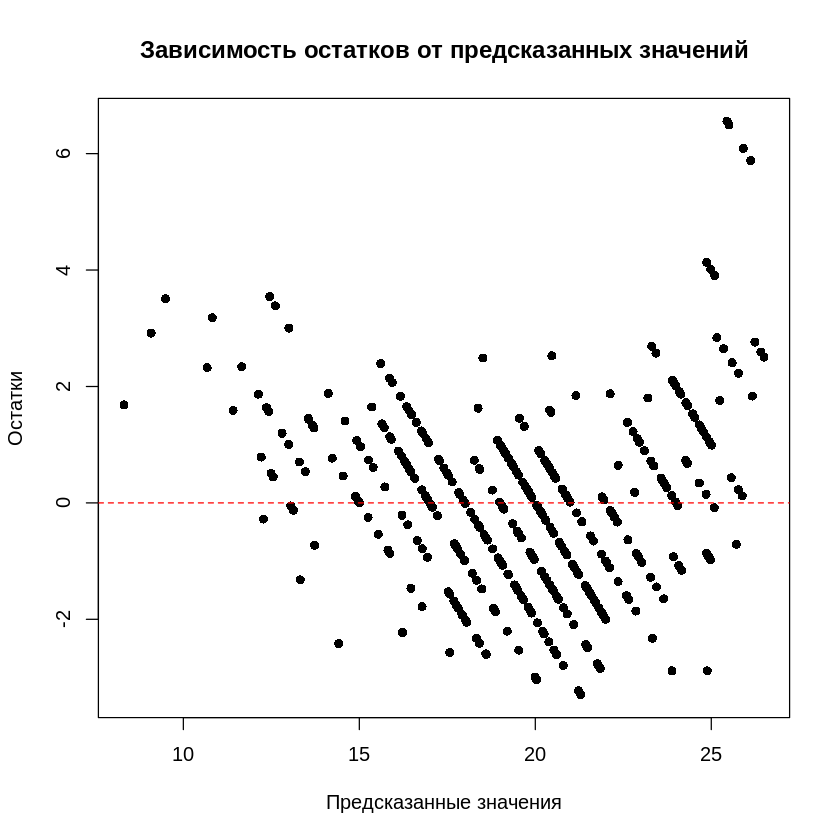

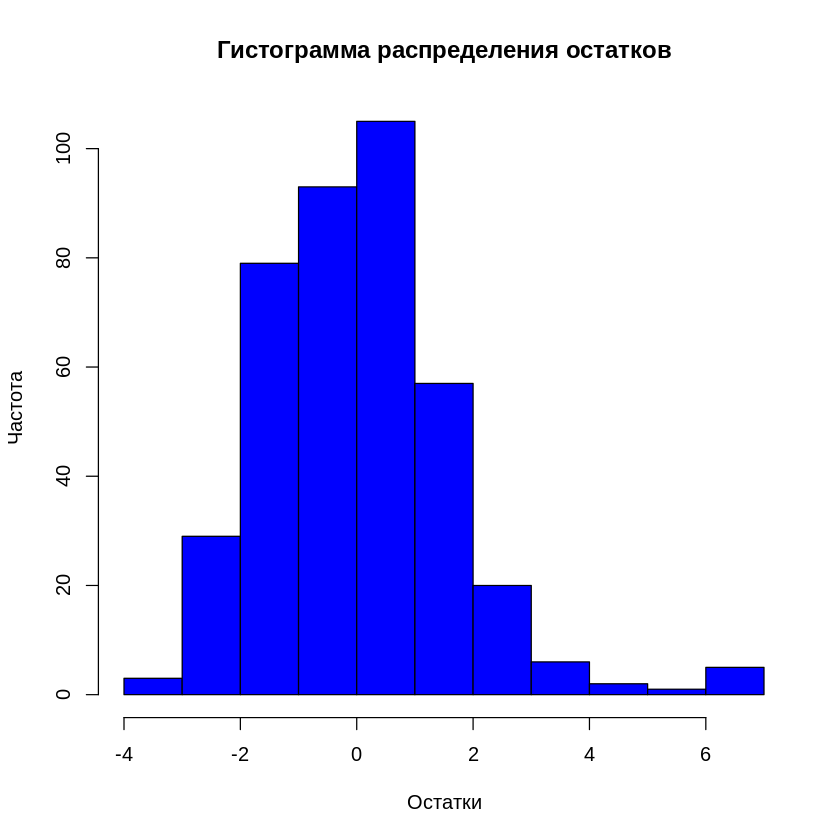

In [161]:
df <- read.csv('CARS.csv')
obj <- MyClass$new()
obj$fit(df,step=3)
obj$summary()
obj$plot()

Статистики R^2 и MSE изменились незначительно. Также и в графиках не наблюдается существенных изменений. BIC незначительно уменьшился, что указывает на то, что данная модель чуть лучше предыдущей

### Пункт 4


Call:
lm(formula = formula_str, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2758 -1.1382 -0.1039  0.8668  7.0779 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          36.2164547  0.4847437  74.713  < 2e-16 ***
Weight               -0.0030909  0.0002095 -14.751  < 2e-16 ***
Horsepower           -0.0121698  0.0022172  -5.489 7.26e-08 ***
TypeSports_and_Truck -1.3832166  0.2518314  -5.493 7.12e-08 ***
TypeSUV_and_Truck    -0.7371124  0.2892867  -2.548   0.0112 *  
Cylinders            -0.4273274  0.1085522  -3.937 9.77e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.667 on 394 degrees of freedom
Multiple R-squared:  0.8142,	Adjusted R-squared:  0.8118 
F-statistic: 345.2 on 5 and 394 DF,  p-value: < 2.2e-16

R^2: 0.8141713 
MSE: 0.811813 
BIC: 1579.69 


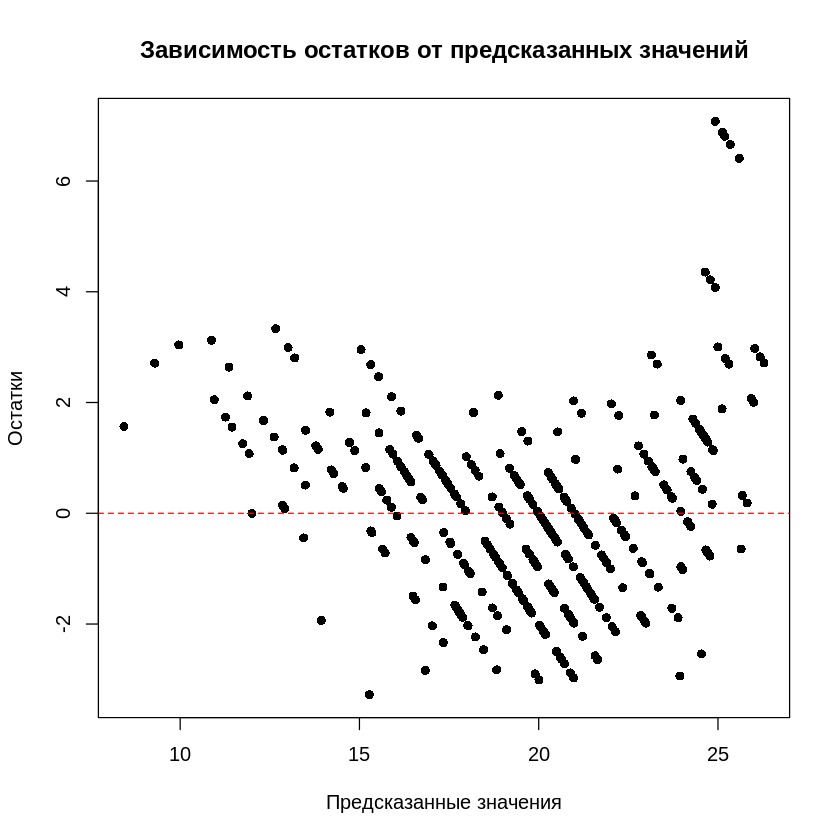

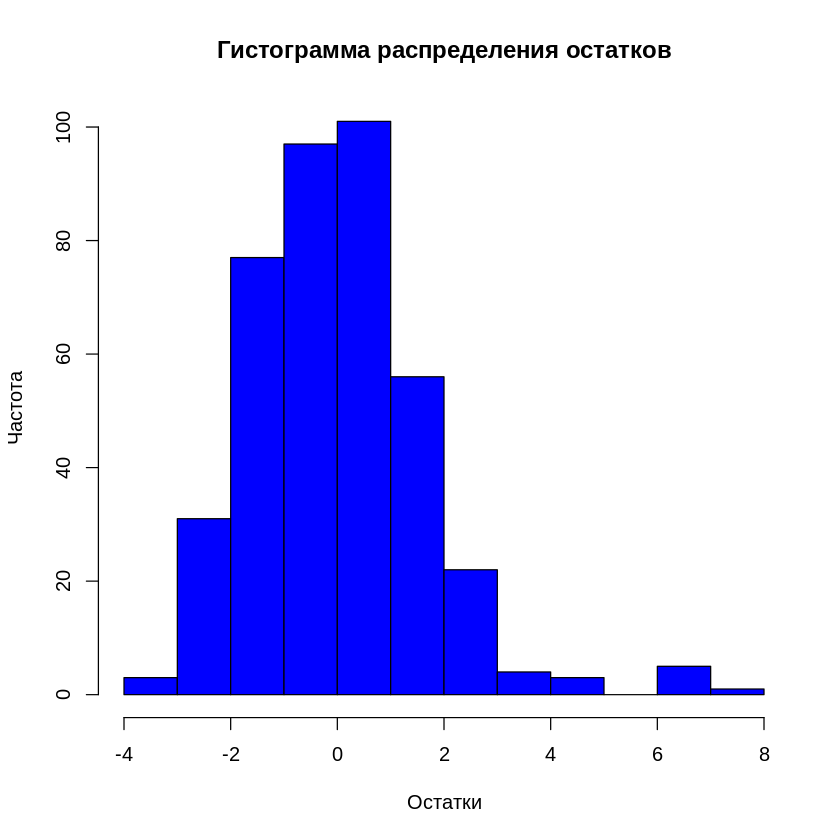

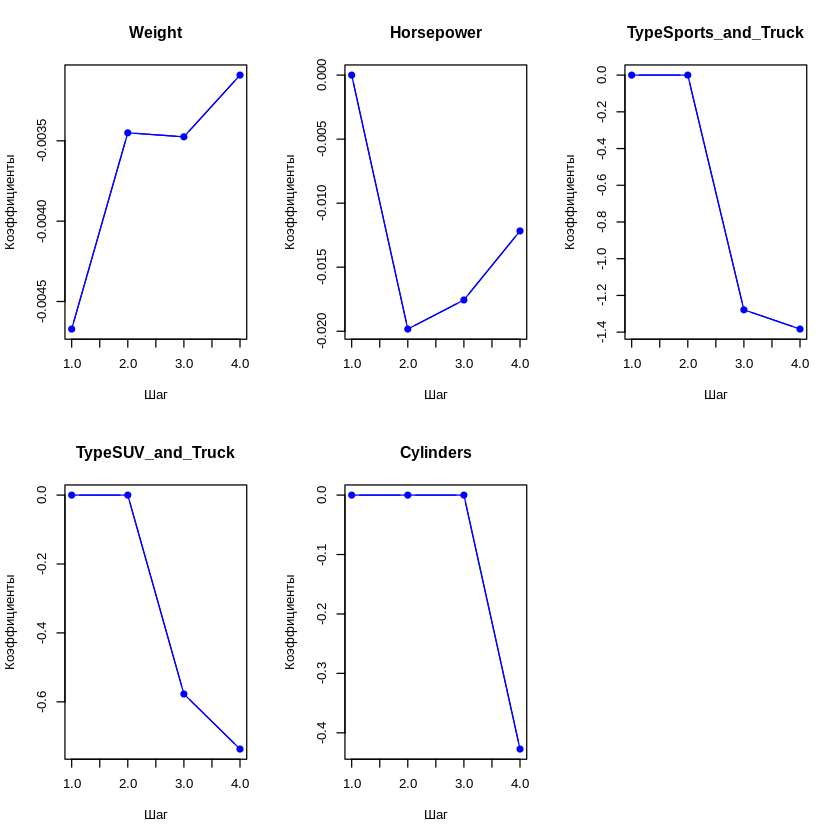

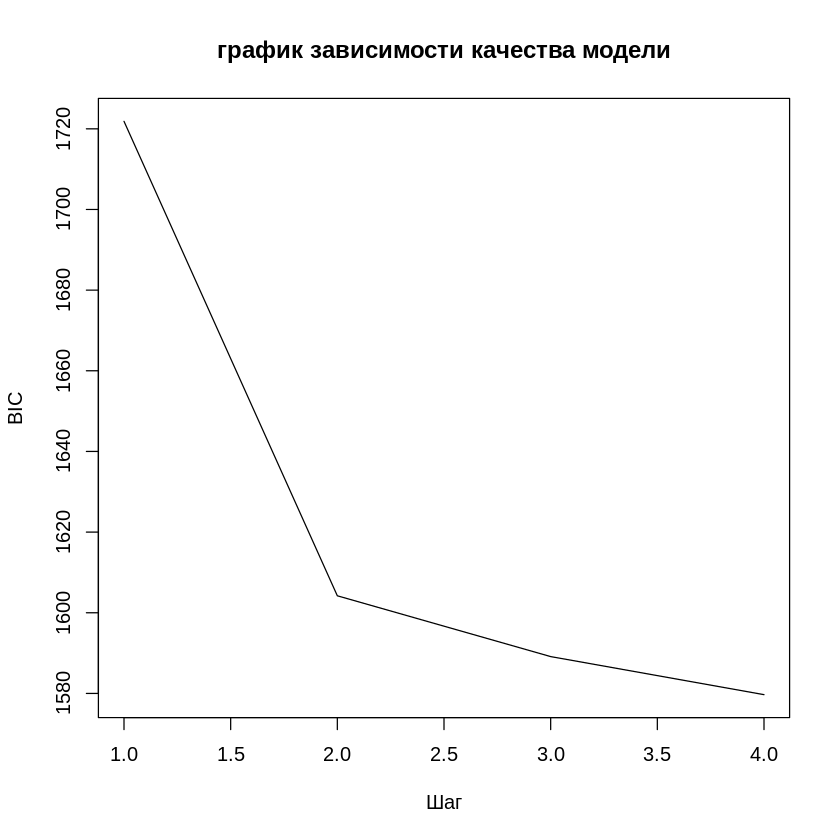

In [162]:
df <- read.csv('CARS.csv')
obj <- MyClass$new()
obj$fit(df,step=4)
obj$summary()
obj$plot()

Значимых изменений статистик по сравнению с предыдущим пунктом не наблюдается, однако удалось убрать из модели незначимые переменные и оставить наиболее значимые, тем самым упростив модель

In [151]:
# install.packages('dplyr')
# install.packages(broom)
# install.packages('ggplot2')
# install.packages('macc')
# install.packages('olsrr')
# install.packages('pls')
# install.packages('reshape2')